# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [1]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd       1007G  6.7G  949G   1% /
Disk space is sufficient: 949G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [2]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为2GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [3]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 devcontainers devcontainers 2.0G Jun 18 20:00 test.txt


In [1]:
!hyperfine --version


hyperfine 1.18.0


In [3]:
!export PATH="$HOME/.cargo/bin:$PATH"  # 临时把 ~/.cargo/bin 加进来
!hyperfine --version
!hyperfine "sleep 0.1" "sleep 0.2"


hyperfine 1.18.0
Benchmark 1: sleep 0.1░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ ETA 00:00:00
  Time (mean ± σ):     101.1 ms ±   0.4 ms    [User: 0.9 ms, System: 0.1 ms]
  Range (min … max):   100.7 ms … 102.9 ms    29 runs
 
 
Benchmark 2: sleep 0.2
  Time (mean ± σ):     201.0 ms ±   0.2 ms    [User: 0.9 ms, System: 0.2 ms]
  Range (min … max):   200.8 ms … 201.6 ms    14 runs
 
Summary
  sleep 0.1 ran
    1.99 ± 0.01 times faster than sleep 0.2


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [4]:
%%bash
cargo install hyperfine

    Updating crates.io index
error: cannot install package `hyperfine 1.19.0`, it requires rustc 1.76.0 or newer, while the currently active rustc version is 1.75.0
`hyperfine 1.18.0` supports rustc 1.70.0


CalledProcessError: Command 'b'cargo install hyperfine\n'' returned non-zero exit status 101.

有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [7]:
%%bash
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt
  Time (mean ± σ):     149.2 ms ±   3.9 ms    [User: 2.8 ms, System: 146.2 ms]
  Range (min … max):   144.5 ms … 160.3 ms    19 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [6]:
%%bash
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt
  Time (abs ≡):        449.240 s               [User: 136.126 s, System: 313.109 s]
 


## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [8]:
%%bash
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):     278.9 ms ±   4.8 ms    [User: 34.8 ms, System: 243.6 ms]
  Range (min … max):   270.8 ms … 284.7 ms    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

In [9]:
%%bash
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):     269.2 ms ±   3.9 ms    [User: 37.0 ms, System: 232.1 ms]
  Range (min … max):   265.0 ms … 278.3 ms    10 runs
 


## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

In [10]:
%%bash
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):     269.7 ms ±   5.7 ms    [User: 35.2 ms, System: 234.2 ms]
  Range (min … max):   261.8 ms … 280.3 ms    11 runs
 


## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

In [12]:
%%bash
set -euo pipefail

# 实验参数
PAGE_SIZE=$(getconf PAGE_SIZE)
# 总共复制的数据量 (例如 256 MiB)，用字节表示
TOTAL=$((256 * 1024 * 1024))

# 把结果存成 CSV 头
echo "multiplier,block_size_bytes,throughput_MB_per_s"

# 测试以下这几组倍数（你也可以增删）
for m in 1 2 4 8 16 32 64 128 256; do
  bs=$(( PAGE_SIZE * m ))
  # 计算 count：总字节数 / 每次块大小
  cnt=$(( TOTAL / bs ))
  # dd iflag=fullblock 确保每次都读满 bs
  # dd 输出类似 "262144+0 records in\n262144+0 records out\n268435456 bytes (268 MB, 256 MiB) copied, 0.224275 s, 1.2 GB/s"
  # 我们用 awk 抽出最后一行的吞吐率字段
  thr=$(dd if=/dev/zero of=/dev/null bs=$bs count=$cnt iflag=fullblock 2>&1 \
          | awk '/ copied,/ { gsub(/,/, "", $0); print $(NF-1) }')
  echo "$m,$bs,$thr"
done


multiplier,block_size_bytes,throughput_MB_per_s
1,4096,19.9
2,8192,37.2
4,16384,54.3
8,32768,80.6
16,65536,46.4
32,131072,63.1
64,262144,66.4
128,524288,59.1
256,1048576,59.6


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families w

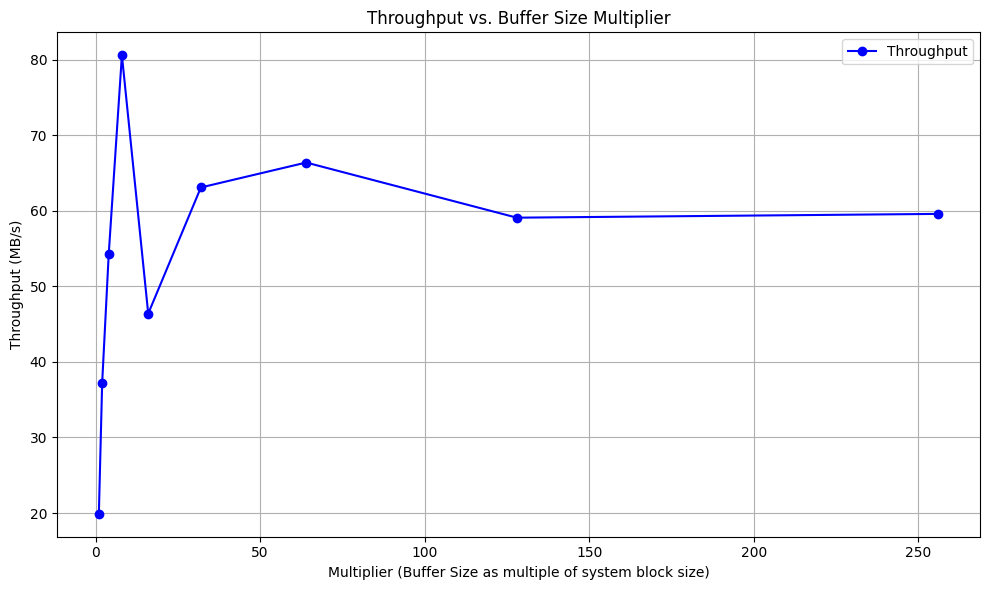

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据
multipliers = [1, 2, 4, 8, 16, 32, 64, 128, 256]
block_sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]
throughput = [19.9, 37.2, 54.3, 80.6, 46.4, 63.1, 66.4, 59.1, 59.6]

# 创建数据框
df = pd.DataFrame({
    "Multiplier": multipliers,
    "Block Size (Bytes)": block_sizes,
    "Throughput (MB/s)": throughput
})

# 绘制图表
plt.figure(figsize=(10,6))
plt.plot(df["Multiplier"], df["Throughput (MB/s)"], marker='o', color='b', label="Throughput")
plt.title("Throughput vs. Buffer Size Multiplier")
plt.xlabel("Multiplier (Buffer Size as multiple of system block size)")
plt.ylabel("Throughput (MB/s)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [13]:
%%bash
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     189.0 ms ±   2.9 ms    [User: 5.3 ms, System: 183.9 ms]
  Range (min … max):   184.9 ms … 193.6 ms    16 runs
 


## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

In [14]:
%%bash
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):     186.1 ms ±   2.9 ms    [User: 5.2 ms, System: 181.1 ms]
  Range (min … max):   182.4 ms … 192.8 ms    16 runs
 


## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

In [1]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 7.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 8.4 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!pip install pandas


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 6.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


,Program,Time_ms
0,cat,149.2
1,mycat1,449240.0
2,mycat2,278.9
3,mycat3,269.2
4,mycat4,269.7
5,mycat5,189.0
6,mycat6,186.1


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, STSong
findfont: Generic family 'sans-serif' not found because none of the following families w

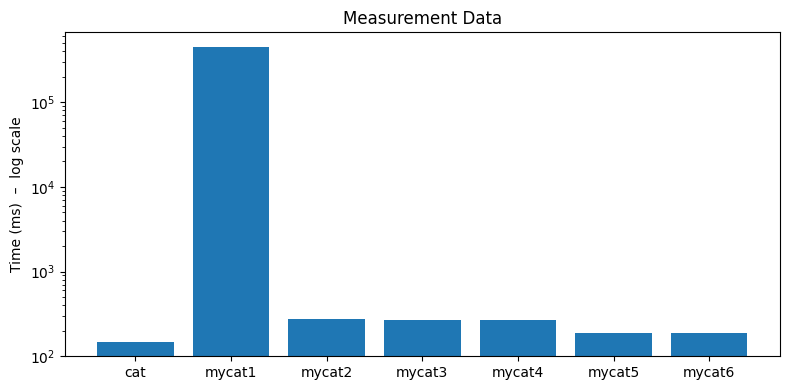

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 所有版本的测量数据（毫秒）
programs = ["cat", "mycat1", "mycat2", "mycat3", "mycat4", "mycat5", "mycat6"]
times_ms = [149.2, 449_240.0, 278.9, 269.2, 269.7, 189.0, 186.1]

df = pd.DataFrame({"Program": programs, "Time_ms": times_ms})
display(df)  # 显示数据表

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'STSong']  # Linux 系统上的常见字体



# 绘制图表
plt.figure(figsize=(8, 4))
plt.bar(df["Program"], df["Time_ms"])
plt.yscale("log")  # 用对数坐标才能把 mycat1 一起放进图里
plt.ylabel("Time (ms)  –  log scale")
plt.title("Measurement Data")
plt.tight_layout()
plt.show()
